In [1]:
import sys
import os
os.environ["STATS_PBAR"] = "1"
from pathlib import Path
sys.path.append(Path.cwd().parent.__str__())
from pprint import pprint
import random
from dronescapes_reader import MultiTaskDataset
from dronescapes_reader.dronescapes_representations import dronescapes_task_types
import numpy as np
from media_processing_lib.collage_maker import collage_fn
from media_processing_lib.image import image_add_title, image_write
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [2]:
reader = MultiTaskDataset("../data/train_set", task_names=list(dronescapes_task_types.keys()),
                          task_types=dronescapes_task_types, handle_missing_data="fill_nan",
                          normalization="min_max", cache_task_stats=True, batch_size_stats=100)
print(reader)
print("== Shapes ==")
pprint(reader.data_shape)

[2024-10-17T18:34:14 DEBUG] Building dataset from: '/scratch/sdc/datasets/dronescapes/scripts/../data/train_set' (multitask_dataset.py:_build_dataset:226)


[2024-10-17T18:34:16 INFO] Total files: 11664 per task across 15 tasks (multitask_dataset.py:_build_dataset:245)
[2024-10-17T18:34:16 INFO] Tasks used in this dataset: ['depth_dpt', 'depth_marigold', 'depth_sfm_manual202204', 'depth_ufo', 'edges_dexined', 'edges_gb', 'hsv', 'normals_sfm_manual202204', 'opticalflow_rife', 'rgb', 'semantic_mask2former_coco_47429163_0', 'semantic_mask2former_mapillary_49189528_0', 'semantic_mask2former_swin_mapillary_converted', 'semantic_segprop8', 'softseg_gb'] (multitask_dataset.py:__init__:83)
[2024-10-17T18:34:16 INFO] Normalization provided as a string (min_max). Setting all tasks to this (multitask_dataset.py:__init__:87)
[2024-10-17T18:34:16 INFO] Loaded task statistics: {'softseg_gb': (3,), 'rgb': (3,), 'normals_sfm_manual202204': (3,), 'edges_gb': (1,), 'semantic_segprop8': (8,), 'edges_dexined': (1,), 'hsv': (3,), 'opticalflow_rife': (2,), 'depth_sfm_manual202204': (1,), 'depth_ufo': (1,), 'depth_dpt': (1,), 'depth_marigold': (1,)} from /scratc

[MultiTaskDataset]
 - Path: '/scratch/sdc/datasets/dronescapes/scripts/../data/train_set'
 - Tasks (15): [DepthRepresentation(depth_dpt[1]), DepthRepresentation(depth_marigold[1]), DepthRepresentation(depth_sfm_manual202204[1]), DepthRepresentation(depth_ufo[1]), EdgesRepresentation(edges_dexined[1]), EdgesRepresentation(edges_gb[1]), HSVRepresentation(hsv[3]), NormalsRepresentation(normals_sfm_manual202204[3]), OpticalFlowRepresentation(opticalflow_rife[2]), RGBRepresentation(rgb[3]), SemanticRepresentation(semantic_mask2former_coco_47429163_0[133]), SemanticRepresentation(semantic_mask2former_mapillary_49189528_0[65]), SemanticMapper(semantic_mask2former_swin_mapillary_converted[8]), SemanticRepresentation(semantic_segprop8[8]), NpzRepresentation(softseg_gb[3])]
 - Length: 11664
 - Handle missing data mode: 'fill_nan'
 - Normalization: '{'depth_dpt': 'min_max', 'depth_marigold': 'min_max', 'depth_sfm_manual202204': 'min_max', 'depth_ufo': 'min_max', 'edges_dexined': 'min_max', 'edges

In [3]:
from dronescapes_reader.dronescapes_representations import SemanticMapper, mapillary_classes, coco_classes

class BuildingsFromM2F(SemanticMapper):
    def __init__(self, original_classes: tuple[list[str], list[str]]):
        mapping = [
            {
                "man-made-construction": ["Building"],
                "others": [x for x in original_classes[0] if x != "Building"]
            },
            {
                "man-made-construction": ["building-other-merged", "house", "roof"],
                "others": [x for x in original_classes[1] if x not in ["building-other-merged", "house", "roof"]]
            }
        ]
        dependencies = ["semantic_mask2former_mapillary_49189528_0", "semantic_mask2former_coco_47429163_0"]
        super().__init__("semantic_buildings_m2f", original_classes=original_classes, mapping=mapping,
                         color_map=[[255, 255, 255], [0, 0, 0]], dependencies=dependencies, merge_fn=self._merge_fn)
    
    def _merge_fn(self, dep_data: list[np.ndarray]) -> np.ndarray:
            return ((dep_data[0] + dep_data[1]) != 0).astype(np.uint8) 

reader.add_task(BuildingsFromM2F([mapillary_classes, coco_classes]))
# reader.remove_task("semantic_buildings_m2f")

[2024-10-17T18:34:17 DEBUG] Adding a new task: 'semantic_buildings_m2f' (multitask_dataset.py:add_task:190)
[2024-10-17T18:34:17 DEBUG] Building dataset from: '/scratch/sdc/datasets/dronescapes/scripts/../data/train_set' (multitask_dataset.py:_build_dataset:226)


[2024-10-17T18:34:19 INFO] Total files: 11664 per task across 16 tasks (multitask_dataset.py:_build_dataset:245)


== Random loaded item ==
slanic_DJI_0956_0957_combined_sliced_780_9780_2622.npz


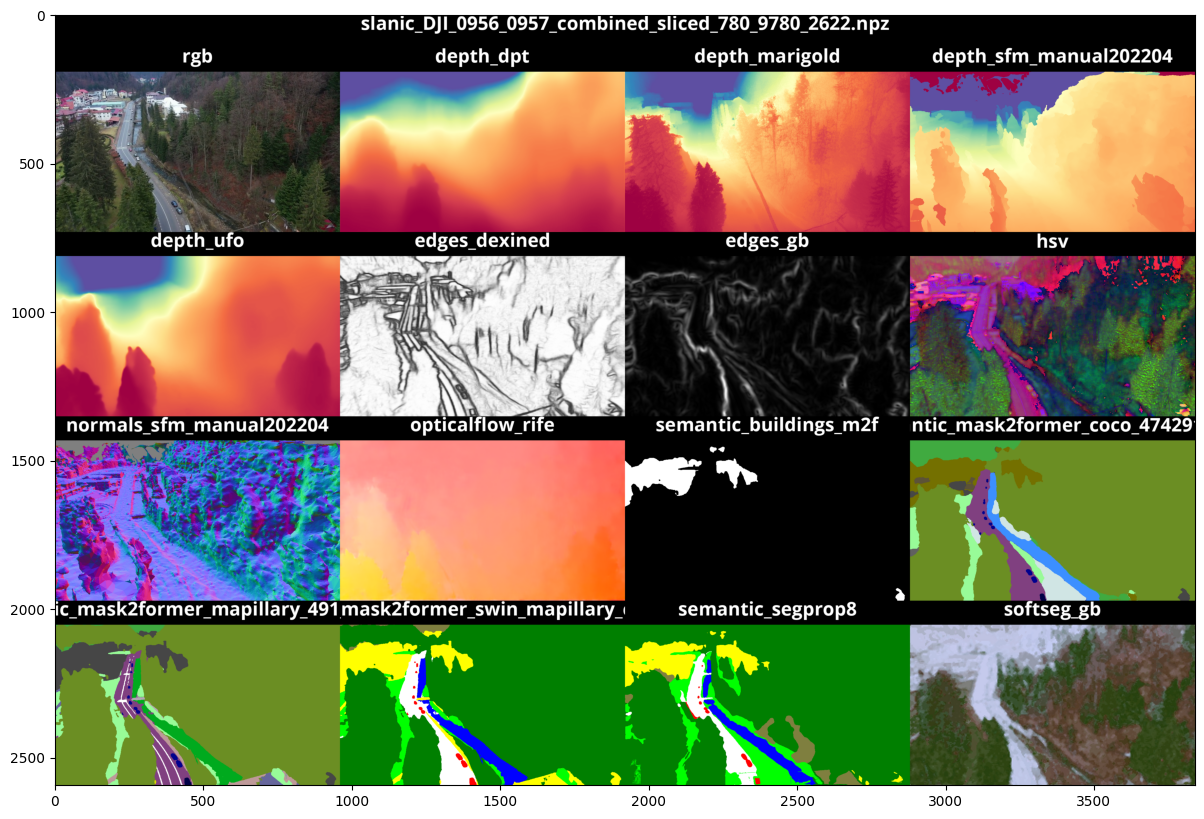

In [5]:
print("== Random loaded item ==")
rand_ix = random.randint(0, len(reader))
data, name, repr_names = reader[rand_ix] # get a random item
print(name)
img_data = {}
for k, v in data.items():
    img_data[k] = reader.name_to_task[k].plot_fn(v) if v is not None else np.zeros((*reader.data_shape[k][0:2], 3))
if "rgb" in img_data: # move rgb as 1st item in the collage
    img_data = {"rgb": img_data["rgb"], **{k: v for k, v in img_data.items() if k != "rgb"}}
# pprint({k: v.shape for k, v in img_data.items()})
collage = collage_fn(list(img_data.values()), titles=img_data.keys(), size_px=55)
collage = image_add_title(collage, name, size_px=55, top_padding=110)
plt.figure(figsize=(20, 10))
plt.imshow(collage)
image_write(collage, f"collage_{name}.png")